In [1]:
import numpy as np
import cvxpy as cp
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

from cvar_proj import  proj_sum_largest

import sys
sys.path.append('/Users/ericluxenberg/Desk/Gridmatic/build')
import mybindings

# use autoreload
%load_ext autoreload
%autoreload 2


In [11]:
def proj_cvxpy(z, k=2, alpha=1):
    z = np.array(z)
    n = len(z)
    
    # Check if the problem object is already in the cache
    if (n, k) in proj_cvxpy.cache:
        prob, alpha_ = proj_cvxpy.cache[(n, k)]
    else:
        x = cp.Variable(n)
        alpha_ = cp.Parameter(nonneg=True) 
        objective = cp.Minimize(cp.sum_squares(x - z))
        constraints = [cp.sum_largest(x, k) <= alpha_]
        prob = cp.Problem(objective, constraints)
        
        # Add the problem object to the cache
        proj_cvxpy.cache[(n, k)] = prob, alpha_
    
    alpha_.value = alpha

    s = time.time()
    _ = prob.solve(solver=cp.MOSEK)
    e = time.time()
    
    solve_time = prob.solver_stats.solve_time
    return solve_time

# Initialize the cache dictionary
proj_cvxpy.cache = {}

def proj_cvxpy_alt(z, k=2, alpha=1):
    z = np.array(z)
    n = len(z)
    x = cp.Variable(n)

    # identify the index of the k-th largest element
    s = time.time()
    sorted_inds = np.argsort(z)
    i = sorted_inds[-k]
    inds = sorted_inds[-k:]
    out_inds = sorted_inds[:-k]
    e = time.time()
    
    objective = cp.Minimize(cp.sum_squares(x - z))
    constraints = [
        cp.sum(x[inds]) <= alpha,
        x[inds] >= x[i],
        x[out_inds] <= x[i]
    ]
    prob = cp.Problem(objective, constraints)

    prob.solve(solver=cp.MOSEK)
    # get the solve time from the solver
    solve_time = prob.solver_stats.solve_time
    return solve_time + e - s



In [12]:
def test(f, beta, tau_r, n):

    z = np.random.uniform(0, 1, n)
    k = int(beta*n)
    alpha = tau_r * cp.sum_largest(z, k).value

    # s = time.time()
    t = f(z,k,alpha)
    # e = time.time()
    return t

In [13]:
f = proj_sum_largest

beta = .05
tau_r = .9
n = 1000
trials = 50

def time_f(f):
    times = np.zeros(trials)
    for i in tqdm(range(trials)):
        s = time.time()
        t = test(f, beta, tau_r,n)
        e = time.time()

        if not isinstance(t, float):
            t = e-s

        times[i] = t
    return times

times_proj = time_f(proj_sum_largest)

F = lambda z, k, alpha: mybindings.sum_largest_proj(z, k, alpha, k, 0, len(z), False)
times_cpp = time_f(F)

_ = test(proj_cvxpy, beta, tau_r,n) # compile problem
times_cvxpy = time_f(proj_cvxpy)

times_alt = time_f(proj_cvxpy_alt)

100%|██████████| 50/50 [00:00<00:00, 63.72it/s]


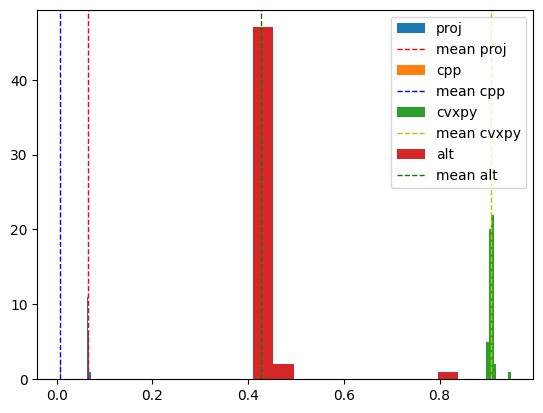

In [56]:
plt.hist(times_proj, label="proj");
plt.axvline(times_proj.mean(), color='r', linestyle='dashed', linewidth=1, label = "mean proj")
plt.hist(times_cpp, label="cpp");
plt.axvline(times_cpp.mean(), color='b', linestyle='dashed', linewidth=1, label = "mean cpp")
plt.hist(times_cvxpy, label="cvxpy");
plt.axvline(times_cvxpy.mean(), color='y', linestyle='dashed', linewidth=1, label = "mean cvxpy")
plt.hist(times_alt, label="alt");
plt.axvline(times_alt.mean(), color='g', linestyle='dashed', linewidth=1, label = "mean alt")
plt.legend()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


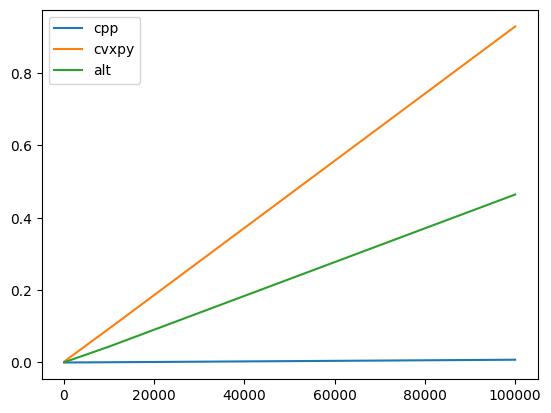

In [14]:
# mu_proj =[]
mu_cpp = []
mu_cvxpy = []
mu_alt = []

ns = [100, 1000, 10000, 100_000] #, 1_000_000]

for n in ns:
    beta = .05
    tau_r = .9
    trials = 50

    def time_f(f):
        times = np.zeros(trials)
        for i in tqdm(range(trials)):
            s = time.time()
            t = test(f, beta, tau_r,n)
            e = time.time()

            if not isinstance(t, float):
                t = e-s

            times[i] = t

        return times
    
    # times_proj = time_f(proj_sum_largest)
    times_cpp = time_f(F)
    times_cvxpy = time_f(proj_cvxpy)
    times_alt = time_f(proj_cvxpy_alt)

    # mu_proj.append(times_proj.mean())
    mu_cpp.append(times_cpp.mean())
    mu_cvxpy.append(times_cvxpy.mean())
    mu_alt.append(times_alt.mean())

# plt.plot(ns, mu_proj, label="proj")
plt.plot(ns, mu_cpp, label="cpp")
plt.plot(ns, mu_cvxpy, label="cvxpy")
plt.plot(ns, mu_alt, label="alt")

plt.legend()



In [62]:
beta = .05
tau_r = .9
trials = 50

n = 1_000_000

def time_f(f):
    times = np.zeros(trials)
    for i in tqdm(range(trials)):
        s = time.time()
        t = test(f, beta, tau_r,n)
        e = time.time()

        if not isinstance(t, float):
            t = e-s

        times[i] = t

    return times

times_cpp_ = time_f(F)

100%|██████████| 50/50 [00:04<00:00, 11.55it/s]


86.2637996673584


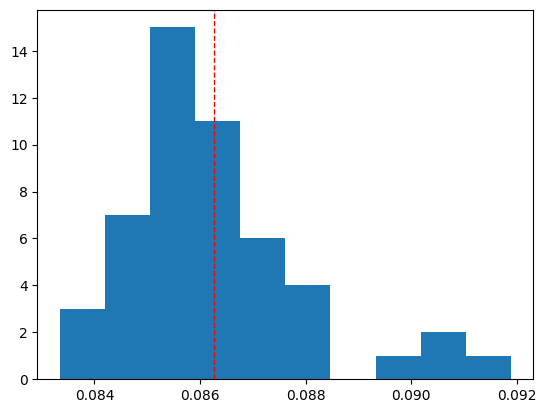

In [65]:
plt.hist(times_cpp_)
plt.axvline(times_cpp_.mean(), color='r', linestyle='dashed', linewidth=1, label = "mean cpp")
# print the mean in milliseconds
print(times_cpp_.mean()*1000)

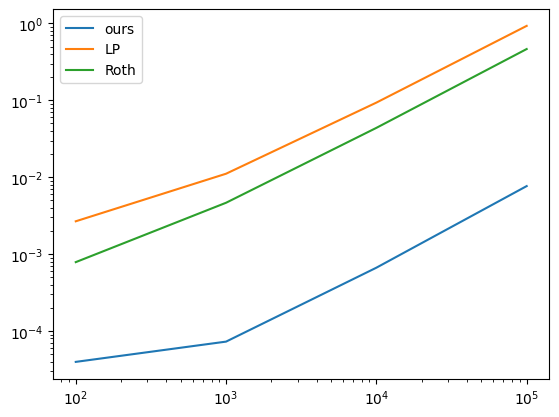

In [15]:
# plt.plot(ns, mu_proj, label="proj")
plt.plot(ns, mu_cpp, label="ours")
plt.plot(ns, mu_cvxpy, label="LP")
plt.plot(ns, mu_alt, label="Roth")

plt.legend()

# make the y,x axis log scale
plt.yscale('log')
plt.xscale('log')

plt.savefig("../cvar-opt/proj_time.pdf")

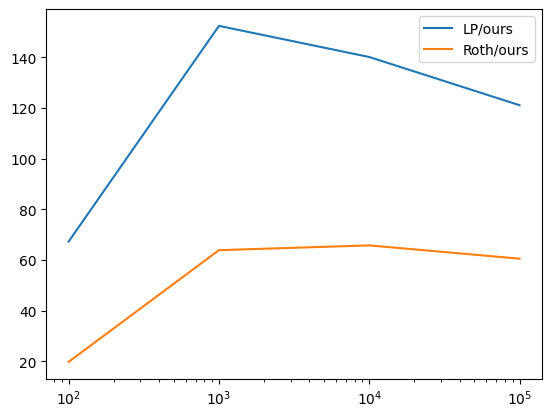

In [17]:
# plot the multiplicative speedup of the proj over the other methods
# plt.plot(ns, np.array(mu_cvxpy)/np.array(mu_proj), label="cvxpy/proj")
# plt.plot(ns, np.array(mu_alt)/np.array(mu_proj), label="alt/proj")
plt.plot(ns, np.array(mu_cvxpy)/np.array(mu_cpp), label="LP/ours")
plt.plot(ns, np.array(mu_alt)/np.array(mu_cpp), label="Roth/ours")

plt.legend()

# make the x axis log scale
plt.xscale('log')
plt.savefig("../cvar-opt/proj_speedup.pdf")